In [1]:
# You can set your own libraries search path by adding M2AIA_PATH to your system environment variables
#  - For installed versions of M2aia point to the /path/to/m2aia/installation/bin directory
#  - For compiled versions of M2aia point to the /path/to/m2aia/build/MITK-build/lib directory

# import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"

In [2]:
#===================================
# 1. Download data
#===================================
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([1,2,3,4])

In [3]:
import m2aia as m2
import torch
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt 

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Adam
import matplotlib.pyplot as plt

In [4]:
#===================================
# 1.1 Load image handles
#===================================
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f)
    xs = I.GetXAxis()
    image_handles.append(I)

[Fri Nov 10 10:28:24 2023 
21.622] [imzML]: data/150429_ew_section1_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 206x107x1
	[num spectra]: 16418
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[46.151] [imzML]: data/150429_ew_section2_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 220x171x1
	[num spectra]: 26744
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[71.715] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 224x169x1
	[num spectra]: 28278
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[98.013] [imzML]: data/150417_ew_section4_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 197x192x1
	[num spectra]: 28156
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 wit

Examples for different neighborhood sizes
-----------------------------------------

N := spectra in neighborhood</br>
D := spectrum depth</br>

```
dataset = m2.SpectrumDataset(image_handles, neighborhood_size=1, buffer_type="memory")
print("3x3 => [N=9,D]",dataset[0].shape)
```

this returns 9 spectra of the 3x3 neighborhood.


```
dataset = m2.SpectrumDataset(image_handles, neighborhood_size=2, buffer_type="memory")
print("5x5 => [N=25,D]",dataset[0].shape)
```
this returns 25 spectra of the 5x5 if neighborhood.


In [7]:
#========================================
# 1.2 Batch generator (with neighborhood)
#========================================

toTorchTensor = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))
dataset = m2.SpectrumDataset(image_handles, shape=(3,3), buffer_type="memory", transform_data=toTorchTensor)
print("3x3 => [B,C=1,D,H=3,W=3]",dataset[0][0].shape)

3x3 => [B,C=1,D,H=3,W=3] torch.Size([1, 29693, 3, 3])


In [8]:
from Example_VI_Helpers import VAE, VAE_Loss
epochs = 5
batch_size = 128
latent_size = 5

m = VAE(xs.shape[-1],interim_dim=512, latent_size=latent_size)
m = m.cuda()

In [9]:
models_root = pathlib.Path('models')
models_root.mkdir(exist_ok=True)
models_path = models_root.joinpath("Example_VI.model")

if models_path.exists():
    #===================================
    # 3A Load trained model parameters
    #===================================
    state_dict = torch.load(str(models_path))
    m.load_state_dict(state_dict)
else:
    #===================================
    # 3B Model training
    #===================================
    loss = VAE_Loss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())

    dataloader = DataLoader(dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        # 1. train
        epoch_losses = []
        for i, batch in enumerate(dataloader):
            
            X = batch.cuda(non_blocking=True)
            R, z, z_mean, z_log_var = m(X)
            
            loss_value = loss(X, R, z_mean, z_log_var)

            # record
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        # scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))

    torch.save(m.state_dict(), str(models_path))

In [11]:
m.eval()

N = 0
ims = []
x_dims = []
y_dims = []
for j, I in enumerate(image_handles):
    x_dim, y_dim, z_dim = I.GetShape()
    im = np.zeros((latent_size, y_dim, x_dim))
    x_dims.append(x_dim)
    y_dims.append(y_dim)
      
    for id in range(I.GetNumberOfSpectra()):
        c, z_mean, z_log_var = m.encoder(dataset[id+N][0][None,...].cuda())
        c = c.cpu().detach().numpy()
        x,y,z = I.GetSpectrumPosition(id)
        im[:, y, x] = c[0,:]
    N = N + I.GetNumberOfSpectra()
    ims.append(im)

No. of Obs. : 715680
Min. Value : -3.4427919387817383
Max. Value : 18.865334510803223
Mean : 2.3900138330226146
Variance : 3.2208904168926114
Skewness : -0.1328775291526095


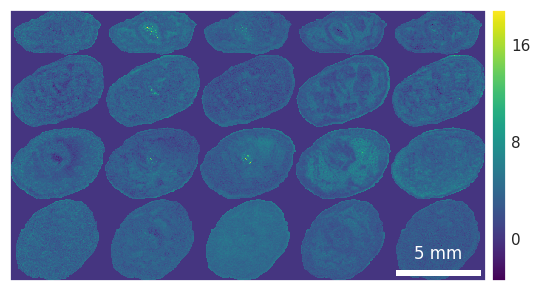

In [ ]:
import seaborn_image as seaim
import seaborn as sns

sns.set_theme(style="darkgrid")
# sns.set(rc={'figure.figsize':(19,6)})
height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_size

im_final = np.zeros((height, width))


y_pos = 0
for i, ims_temp in enumerate(ims):
    d,h,w = ims_temp.shape
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_size):
        rescaled = np.copy(ims_temp[k])
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

im_final[im_final!=0] = im_final[im_final!=0]+3.5
seaim.imgplot(im_final, cmap="viridis", dx=25, units="um", describe=True)
plt.savefig("VI.png", dpi=350)